# Project
## Semantic segmentation of aerial images
### Reppas Dimitris - dhmhtrhsreppas@gmail.com


## Intro

Semantic segmentation is a computer vision task that involves assigning a semantic label, such as  "building", "person", "road", etc., to each pixel in an image. The goal of semantic segmentation is to generate a dense, per-pixel labeling of an image, where each pixel is assigned to a class label based on its semantic content.

Semantic segmentation of aerial images can provide valuable information for a wide range of applications and can help support decision-making in fields such as agriculture, environmental monitoring, disaster response, urban planning, and infrastructure management.

In the scope of this project, we are to develop an intelligent system that segments aerial images. 

#### Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import glob as gb
from matplotlib import pyplot as plt
import seaborn as sns
from patchify import patchify
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.metrics import MeanIoU
from keras.utils import to_categorical, get_custom_objects
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Set the seed for NumPy
np.random.seed(99)

# Set the seed for TensorFlow
tf.random.set_seed(99)

# Set the seed for Python's random module
random.seed(99)

# Set the environment variables for TensorFlow determinism
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set default figure size
plt.rcParams["figure.figsize"] = (8, 6)

# Set default font size
plt.rcParams["font.size"] = 12

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


#### Complementary functions

In [2]:
# Function to generate patches from the original images and further pre-processing
def process_dataset(root_directory, file_extension, is_mask=False):
    dataset = []  # Initialize an empty list to store the dataset

    # Iterate over folders in the root directory
    for folder in os.listdir(root_directory):
        files = gb.glob(root_directory + folder + file_extension)  # Get the file paths with the specified extension in the current folder
        for file in files:
            image = cv2.imread(file, 1)  # Read each image as BGR

            if is_mask:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB if it is a mask

            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Calculate the size of the image along the x-axis
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Calculate the size of the image along the y-axis

            image = Image.fromarray(image)  # Convert the image array to an Image object
            image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop the image to match the patch size

            image = np.array(image)  # Convert the image back to a NumPy array

            patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Create patches from the image

            # Iterate over the patches
            for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                    single_patch = patches[i, j, :, :]

                    if not is_mask:
                        single_patch = (single_patch.astype('float32')) / 255.  # Normalize the patch if it is not a mask
                    single_patch = single_patch[0]  # Take only the first channel of the patch

                    dataset.append(single_patch)  # Add the patch to the dataset list

    return dataset  # Return the dataset

# Function to convert hexadecimal color code to RGB values
def convert_colors_to_rgb(color_dict):
    rgb_dict = {}  # Initialize an empty dictionary to store the RGB values
    
    # Iterate over the class names and colors in the color dictionary
    for class_name, color in zip(color_dict['classes'], color_dict['colors']):
        # Convert the hexadecimal color code to RGB values
        rgb = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
        
        # Store the RGB values in the RGB dictionary with the corresponding class name
        rgb_dict[class_name] = rgb
    
    return rgb_dict  # Return the RGB dictionary

# Function to convert RGB values to labels
def rgb_to_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)  # Create an array of zeros with the same shape as the input label array
    
    # Assign labels based on RGB values
    label_seg[np.all(label == rgb_dict['Building'], axis=-1)] = 0
    label_seg[np.all(label == rgb_dict['Land (unpaved area)'], axis=-1)] = 1
    label_seg[np.all(label == rgb_dict['Road'], axis=-1)] = 2
    label_seg[np.all(label == rgb_dict['Vegetation'], axis=-1)] = 3
    label_seg[np.all(label == rgb_dict['Water'], axis=-1)] = 4
    label_seg[np.all(label == rgb_dict['Unlabeled'], axis=-1)] = 5
    
    label_seg = label_seg[:, :, 0]  # Extract the first channel of the label array
    
    return label_seg  # Return the labeled segmentation map

# Function to compute jacard_coef
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)  # Flatten the true labels
    y_pred_f = K.flatten(y_pred)  # Flatten the predicted labels
    intersection = K.sum(y_true_f * y_pred_f)  # Compute the sum of element-wise multiplication of true and predicted labels
    # Calculate the Jaccard coefficient
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def calculate_class_weights(labels):
    class_weights = {}
    unique_labels = np.unique(labels)
    total_pixels = labels.size

    max_weight = 0
    for label in unique_labels:
        label_count = np.sum(labels == label)
        weight = total_pixels / (len(unique_labels) * label_count)
        class_weights[label] = weight
        if weight > max_weight:
            max_weight = weight

    # Normalize the class weights
    for label in class_weights:
        class_weights[label] /= max_weight

    return class_weights

# Function of our Loss
def create_combined_loss(class_weights):
    dice_loss = sm.losses.DiceLoss(class_weights=list(class_weights.values()))
    focal_loss = sm.losses.CategoricalFocalLoss()

    def combined_loss(y_true, y_pred):
        return dice_loss(y_true, y_pred) + (1 * focal_loss(y_true, y_pred))

    return combined_loss

# Define the weighted cross-entropy loss function
def weighted_cross_entropy_loss(class_weights, num_classes):
    def loss(y_true, y_pred):
        # Convert true labels to one-hot encoding
        y_true_one_hot = K.one_hot(K.argmax(y_true), num_classes)

        # Retrieve the weights for each class from the class_weights dictionary
        weights = [class_weights[i] for i in range(num_classes)]

        # Apply weights to the one-hot encoded true labels
        weighted_true = y_true_one_hot * weights

        # Compute the cross-entropy loss
        loss = K.categorical_crossentropy(weighted_true, y_pred)

        return loss

    return loss

# Function to plot specific train graphs
def show_plots(history):
    plt.figure(figsize=(20, 5))
    plt.style.use('ggplot')

    # Plot loss & val loss
    plt.subplot(1, 3, 1)
    sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='blue', label='Val Loss')
    plt.title('Loss on train vs val set')
    plt.legend(loc='best')

    # Plot accuracy and val accuracy
    plt.subplot(1, 3, 2)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='red', label='Accuracy')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='blue', label='Val Accuracy')
    plt.title('Accuracy on train vs val set')
    plt.legend(loc='best')

    # Plot Jaccard coefficient and val Jaccard coefficient
    plt.subplot(1, 3, 3)
    sns.lineplot(x=history.epoch, y=history.history['jacard_coef'], color='red', label='Jaccard Coef')
    sns.lineplot(x=history.epoch, y=history.history['val_jacard_coef'], color='blue', label='Val Jaccard Coef')
    plt.title('Jaccard Coefficient on train vs val set')
    plt.legend(loc='best')

    plt.show()

# Function to present the evaluation metrics on test set
def show_metrics(y_test, y_pred, class_names):
    # Convert y_test and y_pred from one-hot encoded to class labels
    y_test_argmax = np.argmax(y_test, axis=3)
    y_pred_argmax = np.argmax(y_pred, axis=3)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

    # Calculate IoU for each class
    class_iou = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    mean_iou = np.mean(class_iou)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', square=True, cbar=False,
                     xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report and Mean IoU
    print('\nClassification Report\n')
    print(classification_report(y_test_argmax.flatten(), y_pred_argmax.flatten(), target_names=class_names))

    print('\nMean IoU:', mean_iou)
    
# Function to create a U-Net architecture 
def multi_unet_model(classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS): # Building a U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

## Main code

### Exploratory data analysis and data preparation

Overview of the dataset:

The dataset consists of aerial images that are pixel-wise annotated in 6 classes.The total volume of the dataset is 72 images grouped into eight tiles. The segmentation classes are as follows:

- Building
- Land
- Road
- Vegetation
- Water
- Unlabeled

Principal pre-processing steps:

- Read each image and each respective mask as a BGR image
- Convert the image from BGR to RGB
- Normalize the images
- Generate patches derived from the original images and masks: Using patches in semantic segmentation images is beneficial for several reasons. Patch-based processing optimizes memory usage, enhances local context understanding, and enables effective training and inference for aerial image semantic segmentation tasks. Furthermore, by this method, we were able to increase the image dataset from 72 samples to 1647. The more samples we have the better intelligents systems we can build. This is a fact especially for deep learning architectures. We defined the patch size = 224.

In [3]:
root_directory = './Semantic segmentation dataset/'  # Root directory of the dataset

patch_size = 224  # Size of the patches

In [4]:
image_dataset = process_dataset(root_directory, '/images/*.jpg')  # Process the image dataset 
image_dataset = np.array(image_dataset)  # Convert the image dataset to a NumPy array

mask_dataset = process_dataset(root_directory, '/masks/*.png', is_mask=True)  # Process the mask dataset 
mask_dataset = np.array(mask_dataset)  # Convert the mask dataset to a NumPy array

### A closer look at some samples of our dataset

In the following plot, we show 3 random image samples and the semantic segmentation mask of each sample.

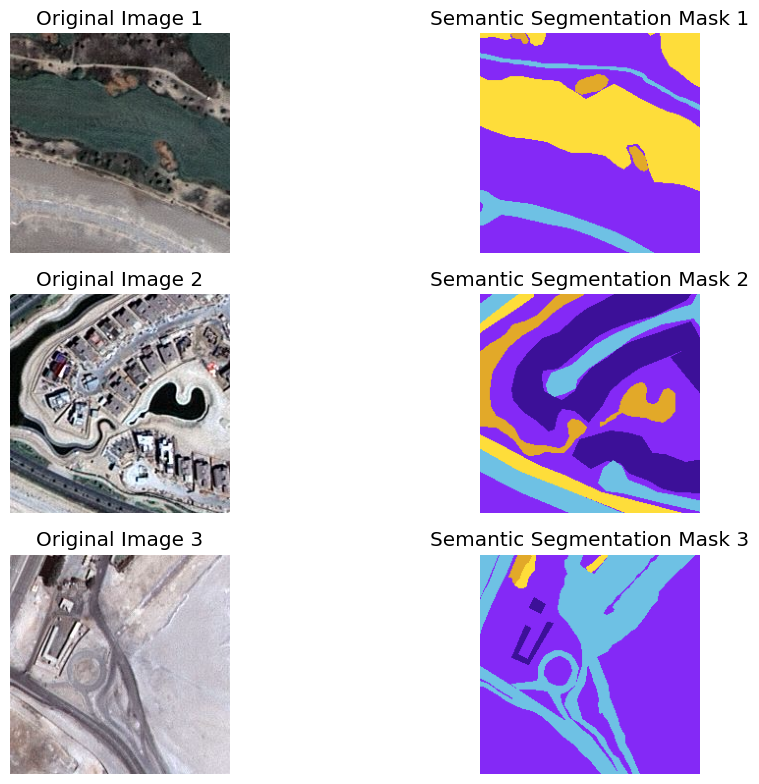

In [5]:
# Select three random indices
random_indices = random.sample(range(len(image_dataset)), 3)

# Plot the random image-mask pairs
plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    image = image_dataset[index]
    mask = mask_dataset[index]

    plt.subplot(3, 2, i * 2 + 1)
    plt.title(f'Original Image {i+1}')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.title(f'Semantic Segmentation Mask {i+1}')
    plt.imshow(mask)
    plt.axis('off')

plt.tight_layout()
plt.show()

Pre-processing of segmentation masks and labels:

- Create a dictionary with the respective classes and colors of each class in hex format(listed in json file)
- Convert hex format to RGB values
- Convert RGB values to labels

In [6]:
color_dict = {
    'classes': ['Building', 'Land (unpaved area)', 'Road', 'Vegetation', 'Water', 'Unlabeled'],
    'colors': ['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']
}

rgb_dict = convert_colors_to_rgb(color_dict) # Convert color codes to RGB values using the provided color dictionary


In [7]:
labels = []  # Initialize an empty list to store the labels

for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])  # Convert each mask image to its corresponding pixel label
    labels.append(label)  # Append the label to the list of labels

labels = np.array(labels)  # Convert the list of labels to a NumPy array

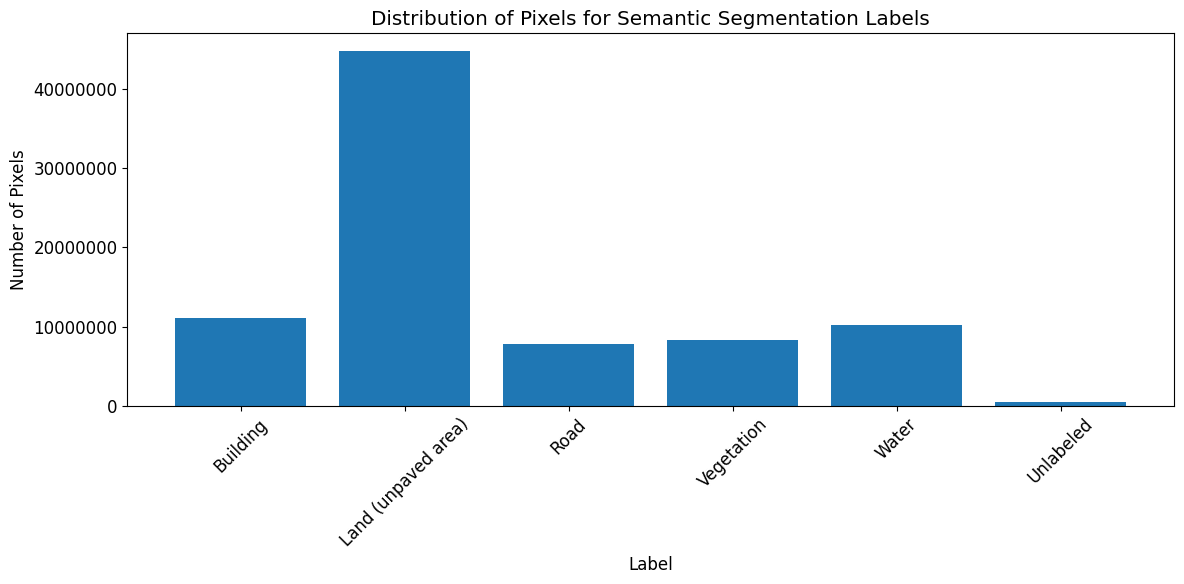

In [8]:
# Count the number of pixels for each label
label_counts = np.bincount(labels.flatten())

# Plotting the histogram
plt.figure(figsize=(12, 6))  # Increase the width of the figure
plt.bar(np.arange(len(label_counts)), label_counts)
plt.xticks(np.arange(len(label_counts)), color_dict['classes'], rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.xlabel('Label')
plt.ylabel('Number of Pixels')
plt.title('Distribution of Pixels for Semantic Segmentation Labels')
plt.ticklabel_format(style='plain', axis='y')  # Set the y-axis labels as plain integers
plt.tight_layout()  # Adjust spacing
plt.show()

From the previous plot, we observe that there is variation in the balance between the 6 categories. An imbalanced dataset used for training can have a negative impact and bias the model in a semantic segmentation problem, just as it can in other machine learning tasks. Imbalanced data refers to a situation where the classes or categories in the dataset are not represented equally, resulting in a significant difference in the number of samples between classes.

We try to mitigate this problem as we will see in our next steps with a class weighting technique. By this technique, we assign higher weights to the minority classes during training to give them more importance and alleviate the bias towards majority classes.


In [9]:
labels = np.expand_dims(labels, axis=3)  # Expand the dimensions of the labels array 
print("The unique labels are: ", np.unique(labels))  # Print the unique labels 

The unique labels are:  [0 1 2 3 4 5]


In [10]:
n_classes = len(np.unique(labels))  # Calculate the number of unique classes in the labels array
labels_cat = to_categorical(labels, num_classes=n_classes)  # Convert the labels to categorical one-hot encoded representation

In [11]:
# Split the original dataset to: 90 % train set, 10 % validation set, 10 % test set
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("Train set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

Train set shapes: (987, 224, 224, 3) (987, 224, 224, 6)
Validation set shapes: (330, 224, 224, 3) (330, 224, 224, 6)
Test set shapes: (330, 224, 224, 3) (330, 224, 224, 6)


The original dataset was divided into a train set, which comprised 90% of the original dataset, a validation set consisting of 10% of the original dataset, and a test set also representing 10% of the original dataset.By this way, we ensure an appropriate distribution of data for training, model evaluation, and testing. This split allows for training the model on a majority of the data, validating its performance on a separate set to fine-tune hyperparameters, and finally evaluating its generalization and performance on unseen data during testing.

By separating the data into different sets, we can monitor and prevent overfitting, where the model memorizes the training data instead of learning generalizable patterns. The validation set helps in detecting overfitting by comparing the model's performance on the training and validation sets

In [12]:
# Find height, width, number of channels of the images
height = X_train.shape[1] 
width  = X_train.shape[2]
channels = X_train.shape[3]
# define the batch size
batch = 32

In [13]:
# Calculate class weights
class_weights = calculate_class_weights(labels)

# Create the combined loss function with class weights
loss_function = create_combined_loss(class_weights)

#loss_function = weighted_cross_entropy_loss(class_weights, n_classes)

class_weights

{0: 0.03671564989371112,
 1: 0.009128231005411788,
 2: 0.05241423980737039,
 3: 0.04920925874053175,
 4: 0.040194427119707506,
 5: 1.0}

To compute the class weights, we take into account the frequency of each class in the dataset and normalize the weights to prevent any individual class from dominating during training. 

The class weights will be fitted to the used Loss function.

The loss function we have created is a combination of two individual loss functions: the Dice Loss and the Categorical Focal Loss. 

- Dice Loss: The Dice Loss is a popular loss function used for evaluating image segmentation tasks. It measures the overlap between the predicted segmentation mask and the true mask by computing the Dice coefficient. The Dice coefficient represents the similarity or agreement between the two masks, with values ranging from 0 to 1 (higher values indicating better overlap). By using the Dice Loss, the model is encouraged to produce segmentation predictions that align closely with the true masks.

- Categorical Focal Loss: The Categorical Focal Loss is another loss function commonly used in multi-class classification tasks, including semantic segmentation. It addresses the issue of class imbalance, where certain classes might be more prevalent in the dataset than others. The Focal Loss assigns higher weights to misclassified samples from minority classes, thereby focusing the model's attention on harder-to-classify examples. This helps in improving the model's ability to handle imbalanced class distributions.

By using the combined loss function in our semantic segmentation problem, we are leveraging the strengths of both the Dice Loss and the Categorical Focal Loss to train a model that can produce accurate and robust segmentation results, even in the presence of class imbalance.


### Creating and fitting a multi U-Net model

Multi-UNet is a type of deep learning architecture that is based on the U-Net architecture, which was originally developed for biomedical image segmentation. The U-Net architecture is known for its ability to effectively handle image segmentation tasks, particularly when there is a need to preserve both fine-grained details and high-level context information. https://arxiv.org/abs/1505.04597v1

A Multi-UNet architecture is an extension of the U-Net architecture that is designed to handle multiple inputs. In this architecture, multiple U-Nets are trained in parallel, each taking a different input and producing a different output. The outputs of all the U-Nets are then combined and fed through a final layer to produce the final output.

In [14]:
# Create the U-Net model
model = multi_unet_model(classes=n_classes, IMG_HEIGHT=height, IMG_WIDTH=width, IMG_CHANNELS=channels)

# Define the metrics to be used during training and evaluation
metrics = ['accuracy', jacard_coef]

# Compile the model
model.compile(optimizer='adam', loss=loss_function, metrics=metrics)

# Print a summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 224, 224, 6)  102         ['conv2d_13[0][0]']              
                                                                                                  
Total params: 1,031,238
Trainable params: 1,031,238
Non-trainable params: 0
__________________________________________________________________________________________________



During the training of the semantic segmentation model, the following evaluation metrics will be used:

- Accuracy: Accuracy measures the percentage of correctly classified pixels or regions in the segmentation mask compared to the ground truth. It provides an overall assessment of how well the model is performing in terms of correct classification.

- Loss: Loss represents the value of the loss function being optimized during training. It quantifies the discrepancy between the predicted segmentation mask and the true mask. Minimizing the loss helps the model learn and improve its segmentation performance.

- Jaccard coefficient (IoU): The Jaccard coefficient, also known as the Intersection over Union (IoU), is a commonly used metric for evaluating segmentation tasks. It measures the overlap between the predicted segmentation mask and the true mask, divided by the total area of union between the two masks.

During training, these metrics can be computed at each iteration or epoch to monitor the model's performance and assess its progress.

Also, we use the following callbacks to provide functionality for early stopping, learning rate adjustment, and saving the best model during training. These techniques help to improve training efficiency, prevent overfitting, and allow us to retain the best-performing model for further use.

Here we want to mention that we tried experiments where we performed augmentations on the fly on the training set (without increasing the data set size further) but the results were not as good as expected. Probably due to the sensitivity to input variations. Semantic segmentation models are often sensitive to input variations, such as changes in object scale, orientation, or appearance. Augmentations applied only to the training set introduce variability in the training data, which can result in different predictions and potentially affect the validation error or test error.

Having in mind that we do not have sufficient resources to perform quickly many experiments, we preferred to keep it simple and train our model with the original train set and validate it on the original validation set.

In [15]:
# Define data augmentation settings
#data_augmentation = ImageDataGenerator(
#    width_shift_range=0.1,  # Random horizontal shift within 10% of the image width
#    height_shift_range=0.1,  # Random vertical shift within 10% of the image height
#    shear_range=0.1,  # Random shear transformation within 10 degrees
#    zoom_range=0.1,  # Random zoom within 10%
#    horizontal_flip=True,  # Random horizontal flip
#    vertical_flip=True,  # Random vertical flip
#    fill_mode='reflect'  # Reflect the image at the boundaries for smoothness
#)

# Create augmented training generator
#train_generator = data_augmentation.flow(X_train, y_train, batch_size=batch)

In [16]:
# Define EarlyStopping callback
EarlyStop = EarlyStopping(patience=4, restore_best_weights=True)

# Define ReduceLROnPlateau callback
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)

# Define ModelCheckpoint callback
model_check = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

# Create a list of callbacks
callback = [EarlyStop, Reduce_LR, model_check]

# Train the model 

history1 = model.fit(X_train, y_train,
                    batch_size = batch, 
                    verbose=1, 
                    epochs=80, 
                    callbacks=callback,
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/80
31/31 [==============================] - ETA: 0s - loss: 1.0287 - accuracy: 0.4937 - jacard_coef: 0.1982
Epoch 1: val_loss improved from inf to 1.02324, saving model to model.hdf5
31/31 [==============================] - 152s 5s/step - loss: 1.0287 - accuracy: 0.4937 - jacard_coef: 0.1982 - val_loss: 1.0232 - val_accuracy: 0.5505 - val_jacard_coef: 0.2368 - lr: 0.0010
Epoch 2/80
31/31 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.5675 - jacard_coef: 0.2450
Epoch 2: val_loss improved from 1.02324 to 1.01791, saving model to model.hdf5
31/31 [==============================] - 145s 5s/step - loss: 1.0212 - accuracy: 0.5675 - jacard_coef: 0.2450 - val_loss: 1.0179 - val_accuracy: 0.6343 - val_jacard_coef: 0.2872 - lr: 0.0010
Epoch 3/80
31/31 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.6522 - jacard_coef: 0.3184
Epoch 3: val_loss improved from 1.01791 to 1.01056, saving model to model.hdf5
31/31 [==============================

Epoch 23/80
31/31 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.8142 - jacard_coef: 0.5487
Epoch 23: val_loss did not improve from 0.98539
31/31 [==============================] - 129s 4s/step - loss: 0.9898 - accuracy: 0.8142 - jacard_coef: 0.5487 - val_loss: 0.9898 - val_accuracy: 0.8157 - val_jacard_coef: 0.5829 - lr: 0.0010
Epoch 24/80
31/31 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.8055 - jacard_coef: 0.5362
Epoch 24: val_loss did not improve from 0.98539
31/31 [==============================] - 127s 4s/step - loss: 0.9903 - accuracy: 0.8055 - jacard_coef: 0.5362 - val_loss: 0.9885 - val_accuracy: 0.8062 - val_jacard_coef: 0.5858 - lr: 0.0010
Epoch 25/80
31/31 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.8068 - jacard_coef: 0.5369
Epoch 25: val_loss did not improve from 0.98539
31/31 [==============================] - 127s 4s/step - loss: 0.9898 - accuracy: 0.8068 - jacard_coef: 0.5369 - val_loss: 0

In [17]:
# Define EarlyStopping callback
#EarlyStop = EarlyStopping(patience=4, restore_best_weights=True)

# Define ReduceLROnPlateau callback
#Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)

# Define ModelCheckpoint callback
#model_check = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

# Create a list of callbacks
#callback = [EarlyStop, Reduce_LR, model_check]

# Train the model with data augmentation
#history1 = model.fit(
#    train_generator,
#    steps_per_epoch=len(X_train) // batch,
#    epochs=80,
#    callbacks=callback,
#    validation_data=(X_val, y_val),
#    shuffle=True
#)

In [18]:
# Load the model
model = load_model('model.hdf5', custom_objects={'combined_loss': loss_function, 'jacard_coef': jacard_coef})

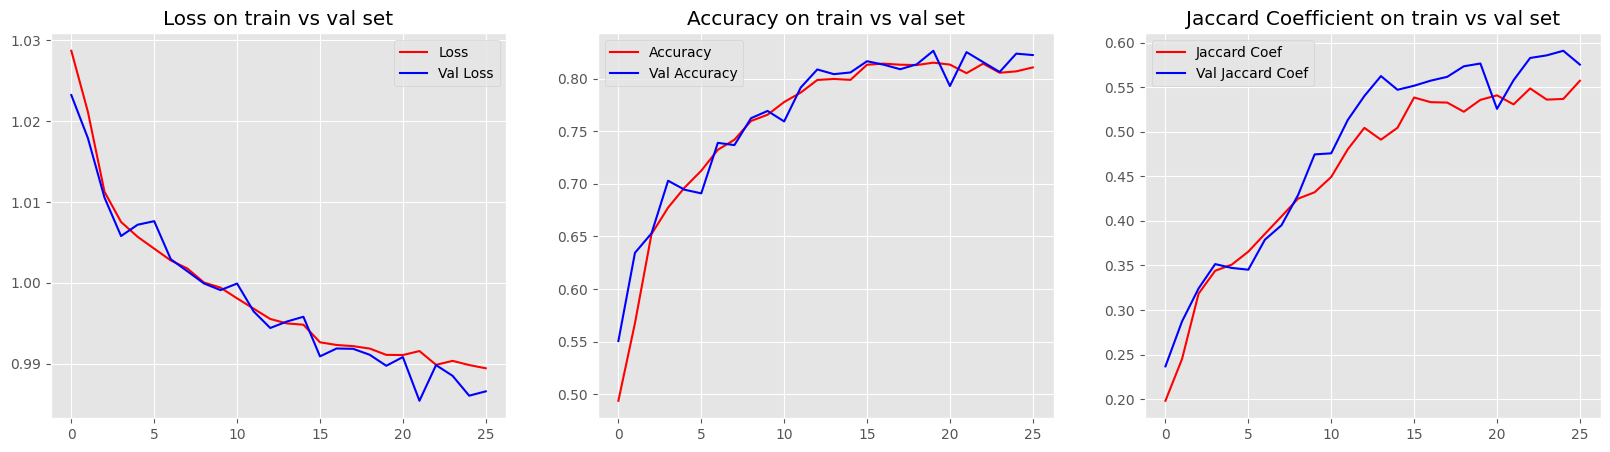

In [19]:
# function to show loss, accuracy, jaccard coef plots during training 
show_plots(history1)

### Discussion of Learning curves

During training, we used Early stopping on validation loss with patience = 4 in order to avoid overfitting. In our case, the experiment stopped in the 26 epoch. From the three Figures, it is observed that both Loss and Val Loss have in general the same behaviour as the number of epochs arises until the point the Val loss starts to increase in value. The optimum point to stop the train is this point. In our case, we have the smallest Val loss in the 22 epoch. After this epoch, the Val loss starts to increase. Again the learning must be stopped here because otherwise ,we will lead our model to overfitting. If we continue the training probably the train Loss curve will be reduced, but the Val Loss will follow an upward course at the same time, which is not desirable.

Accuracy and Val Accuracy have the same behaviour as the number of epochs arises until the point the Val Accuracy starts to decrease in value. Again the optimum Val Accuracy was found in the 22 epoch and after this point, its value was being decreased and this was a sign that the Learning process should be stopped.

The observations from the third Figure are exactly the same and can be explained accordingly.


In [20]:
# Generate predictions on the test data
y_pred = model.predict(X_test)

11/11 [==============================] - 6s 531ms/step


To evaluate our model on test set we used:

- Confusion matrix: A matrix that shows the count of true positive, true negative, false positive, and false negative predictions for each class, providing a detailed overview of the model's classification performance.
- Precision: The proportion of correctly predicted positive instances (true positives) out of the total instances predicted as positive, indicating the model's accuracy in identifying true positives.
- Recall: The proportion of correctly predicted positive instances (true positives) out of the total actual positive instances, measuring the model's ability to capture all positive instances.
- F1-score: The harmonic mean of precision and recall, providing a balanced measure of the model's performance by considering both precision and recall together.
- Accuracy: The proportion of correctly classified instances (both true positives and true negatives) out of the total instances, representing the overall correctness of the model's predictions.
- Mean IoU (Intersection over Union): The average overlap between the predicted segmentation masks and the true masks across all classes, indicating the quality of the model's segmentation performance in terms of capturing the extent of the segmented objects.

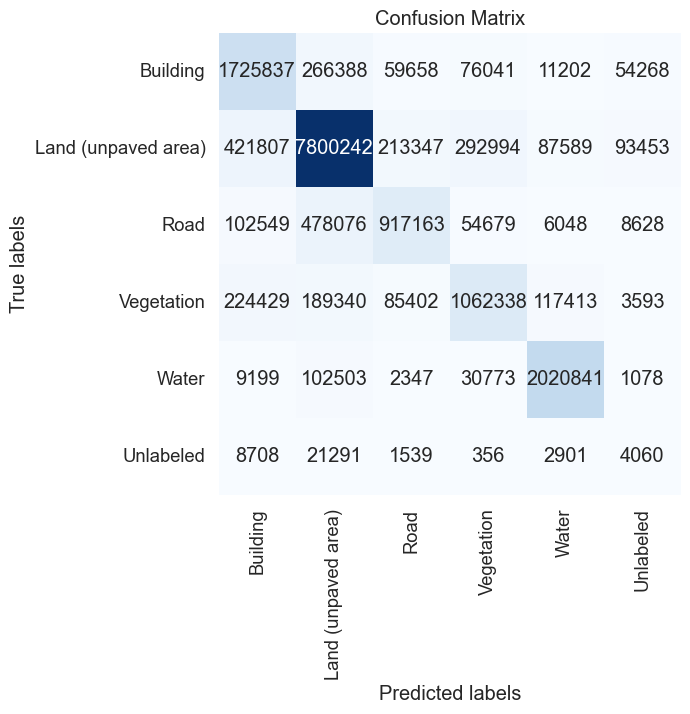


Classification Report

                     precision    recall  f1-score   support

           Building       0.69      0.79      0.74   2193394
Land (unpaved area)       0.88      0.88      0.88   8909432
               Road       0.72      0.59      0.64   1567143
         Vegetation       0.70      0.63      0.66   1682515
              Water       0.90      0.93      0.92   2166741
          Unlabeled       0.02      0.10      0.04     38855

           accuracy                           0.82  16558080
          macro avg       0.65      0.65      0.65  16558080
       weighted avg       0.82      0.82      0.82  16558080


Mean IoU: 0.5338683385719502


In [21]:
# show confusion matrix accuracy, precision, recall,  f1-score and Mean IoU
show_metrics(y_test, y_pred, color_dict['classes'])

### Discussion of the Resuls¶

By observing both the Confusion matrix, Classification report and mean IoU on test data, one could easily see that:

- The results suggest that the model performs reasonably well for most classes, with varying precision, recall, and f1-score values. However, the class "Unlabeled" has extremely low precision and recall, indicating poor performance in identifying that particular class.

- The accuracy of 0.82 indicates that, on average, the model correctly classifies 82% of the pixels in the test set. The macro average F1-score and weighted average F1-score are indicating decent overall performance.

- The mean IoU of 0.53 suggests that, on average, the predicted segmentation masks have a moderate overlap with the true masks.





### Inference module

In this section of the Project, we provide visualizations of 5 random sampled outputs, derived from test set, portraying the aerial image and the ground truth mask, along with the corresponding segmentation prediction. As we see, the moderate performance reached from this model in the previous steps justifies the similarity results of the ground truth masks and corresponding segmentation predictions.

1/1 [==============================] - 0s 44ms/step


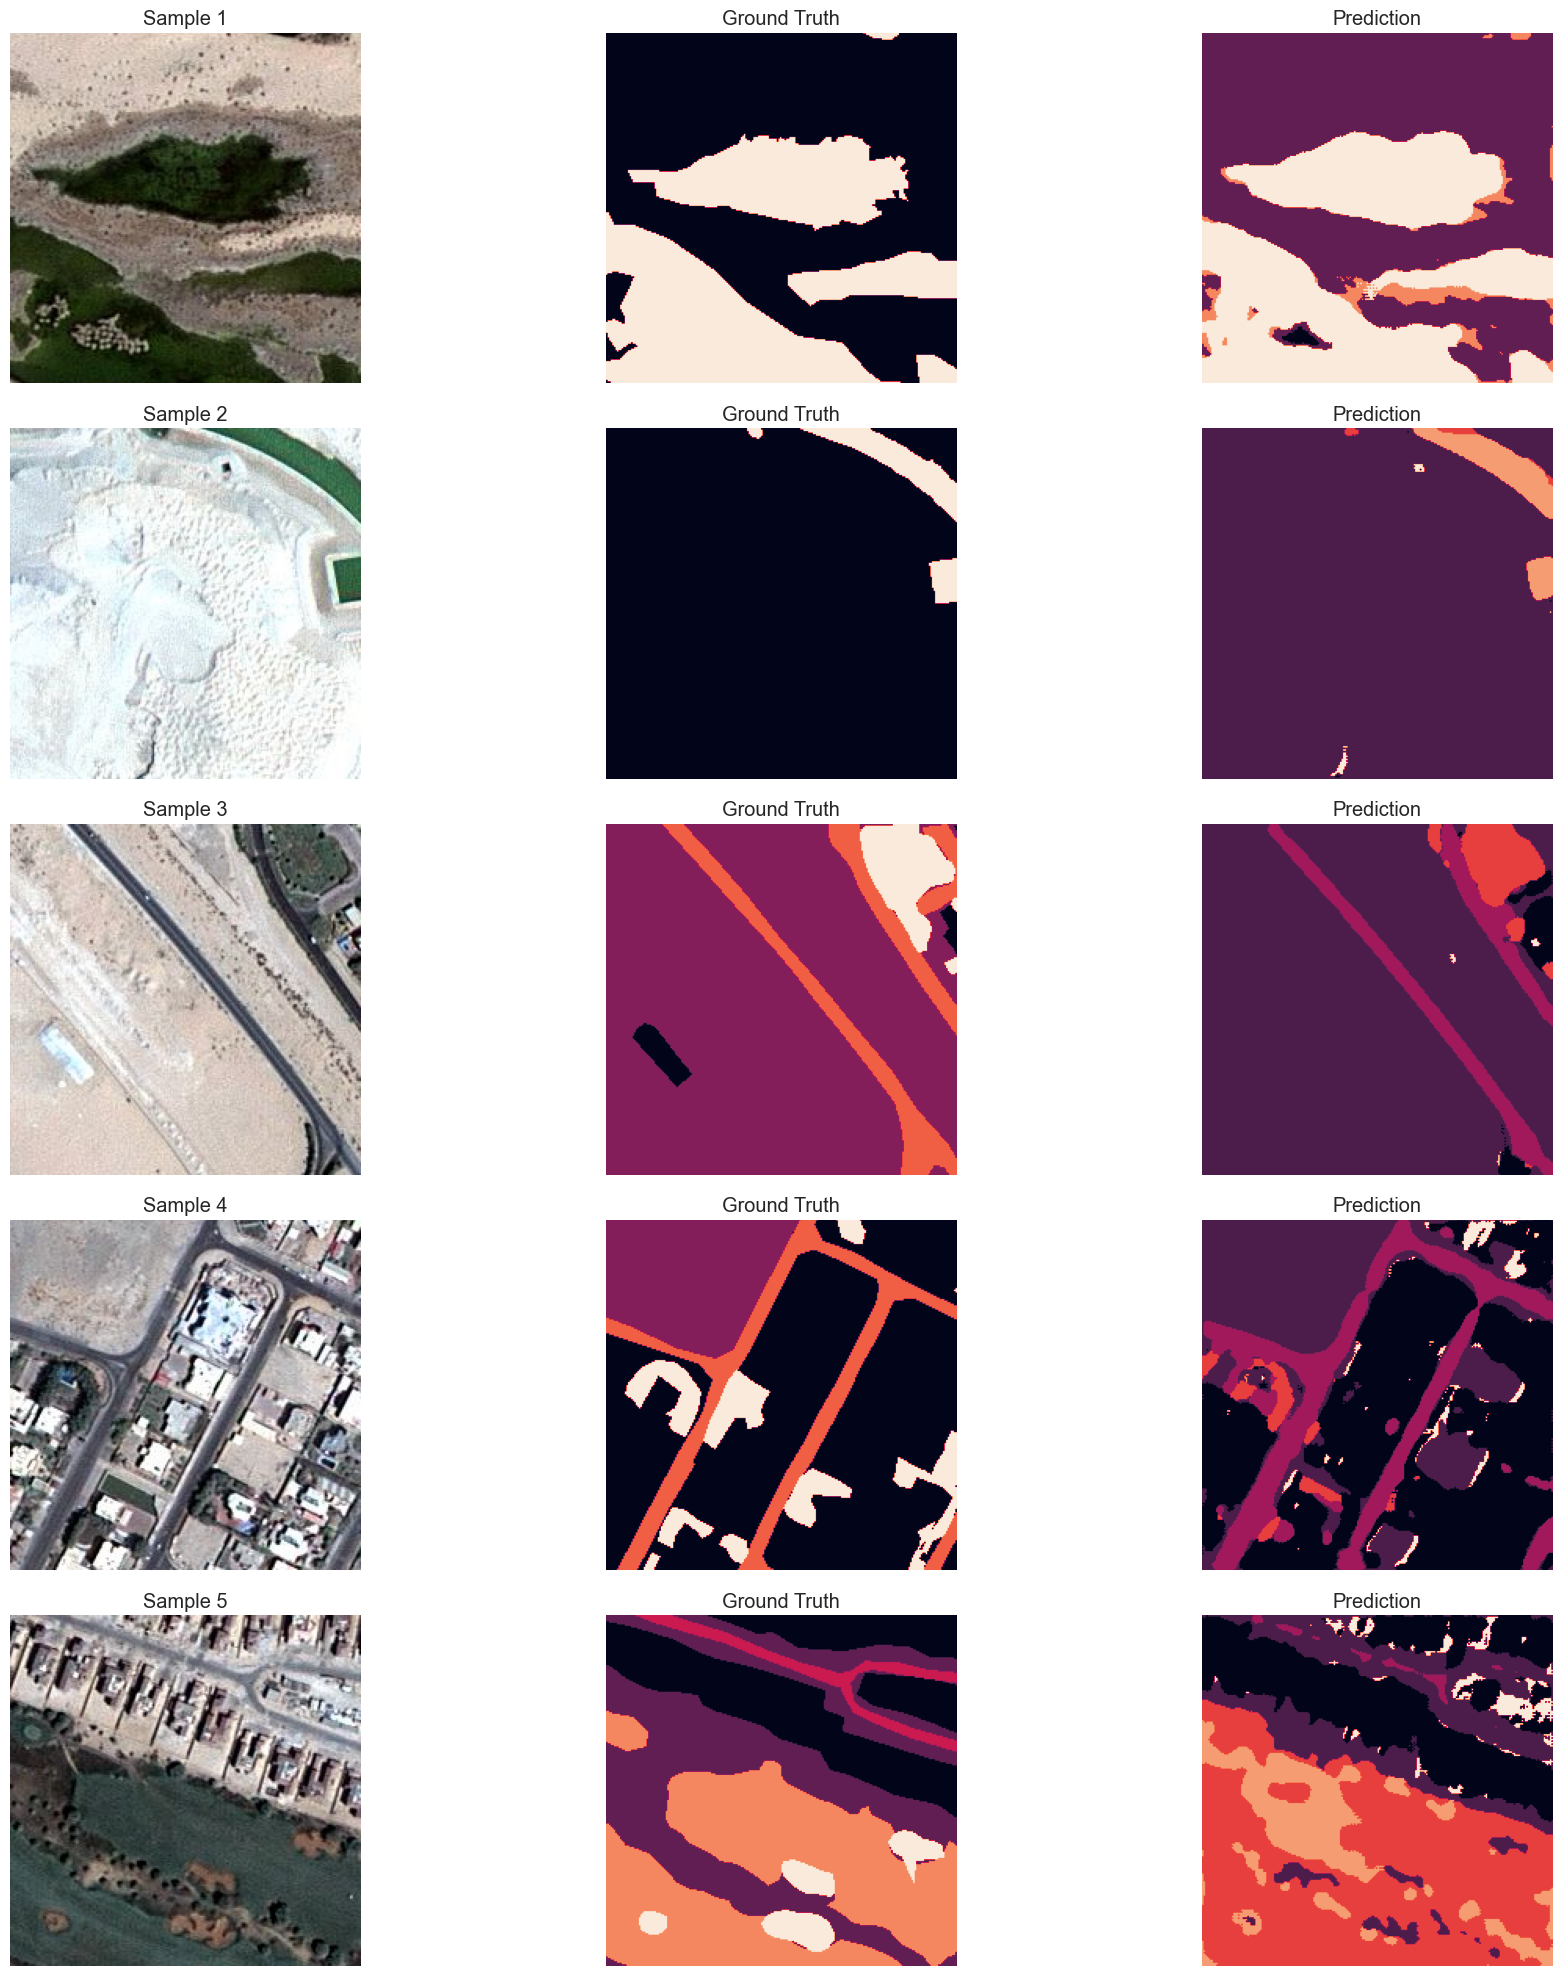

In [22]:
# Generate 5 random sample indices
sample_indices = random.sample(range(len(X_test)), 5)

# Plot the samples
plt.figure(figsize=(20, 20))

for i, index in enumerate(sample_indices, 1):
    test_img = X_test[index]
    y_test_argmax = np.argmax(y_test, axis=3)
    ground_truth = y_test_argmax[index]

    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]

    # Plotting the images
    plt.subplot(5, 3, (i - 1) * 3 + 1)
    plt.title('Sample {}'.format(i))
    plt.imshow(test_img)
    plt.axis('off')

    plt.subplot(5, 3, (i - 1) * 3 + 2)
    plt.title('Ground Truth')
    plt.imshow(ground_truth)
    plt.axis('off')

    plt.subplot(5, 3, (i - 1) * 3 + 3)
    plt.title('Prediction')
    plt.imshow(predicted_img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

To conclude, the main focus of this project relied on the semantic segmentation of aerial images. Semantic segmentation is a challenging and time-consuming problem due to the need to capture fine details and spatial relationships accurately. The obtained results highlight the complexity of the task. Both quantitative and qualitative results show a moderate performance of our model.
